# MODELOS

# NUESTROS DATOS

El punto de partida de nuestro proyecto es el conjunto de datos de Kaggle **'Make Data Count'**.
 No estabamos trabajando con números o tablas convencionales. Nuestro material en bruto es texto, específicamente, fragmentos extraídos de publicaciones científicas reales.

Aunque la implementación de diversos modelos de machine learning fue un componente clave de nuestro proyecto, la etapa más ardua y fundamental fue, sin duda, el procesamiento y la limpieza de los datos. Nuestro material de trabajo no eran números limpios, sino texto científico, un lenguaje denso, lleno de matices y "ruido" que una máquina no puede interpretar de forma nativa.

El éxito o fracaso de todo el proyecto dependía de nuestra capacidad para transformar este texto complejo en un formato estructurado y significativo que los modelos pudieran entender.


## PAQUETERIAS

In [24]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree

stopwords = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lazar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## LECTURA DE DATOS

In [2]:
data = pd.read_csv("../data/processed_articles.csv")
data.head()

,article_id,dataset_id,type,surrounding_text,relative_location
0,10.1002_2017jc013030,https://doi.org/10.17882/49388,Primary,Biogeochemical Argo oat measurements for bioge...,0.628737
1,10.1002_ece3.5260,https://doi.org/10.5061/dryad.2f62927,Primary,design experiments and Adephaga_2.9Kv1 final p...,0.747107
2,10.1002_ecs2.1280,https://doi.org/10.5061/dryad.p3fg9,Primary,Data associated with this paper have been depo...,0.994695
3,10.1007_s00259-022-06053-8,https://doi.org/10.7937/tcia.2019.30ilqfcl,Secondary,from the ACRIN 6668 Trial NSCLC-FDG-PET. Cance...,0.841804
4,10.1016_j.jobe.2023.107105,https://doi.org/10.5281/zenodo.8014150,Primary,and Anh [30] further explored crack 1 Dataset ...,0.179820


## LIMPIEZA DE DATOS 

Esta sección es, sin duda muy importante para el desarrollo de todo el proyecto. Antes de poder entrenar cualquier modelo, teníamos que enfrentar el desafío principal: nuestro texto era 'sucio', desordenado y no estructurado. El objetivo de esta fase era tomar el texto original, que es desordenado, y dejarlo listo para que el modelo lo pueda entender.

Para lograrlo, hicimos tres cosas principales:


*   Eliminamos lo Innecesario: Quitamos todas las palabras de relleno que no aportan significado, además de los números y todos los signos de puntuación.
*   Estandarizamos el Texto: Convertimos todo a minúsculas y elimina los espacios en blanco sobrantes para que el texto sea uniforme.
*   Convertimos las etiquetas a números: Convertimos las categorías de texto como "primary" y "secondary" a números ("0" y "1"), que es el único lenguaje que el modelo entiende.

En reusmen: definimos las funciones que nos ayudaran a obtener los tokens sin datos extra

In [3]:
def remove_stopwords(text):
    for i in stopwords:
        text = re.sub(r"\b%s\b" % i, " ", text)
    return text

def clean_tokens(text): 
    '''
    Esta función limpia textos
    '''

    text = text.lower()

    text = remove_stopwords(text)

    text = re.sub(r"\d+", '', text)

    text = re.sub(r" +", " ", re.sub(r"\t", " ", re.sub(r"\n+", "\n", re.sub(r'(?:[.,\/!$%?¿?!¡\^&\*;:{}=><\-_`~()”“"\'\|])', "",text))))

    text = text.strip()

    return text  

def numerical_type(text):

    text = text.lower()

    text = re.sub(r"primary", '0', text)

    text = re.sub(r"secondary", '1', text)

    text = text.strip()

    return text  

In [4]:
data['clean_surrounding_text'] = data['surrounding_text'].apply(lambda x: clean_tokens(x))
data['numerical_type'] = data['type'].apply(lambda x: numerical_type(x))

data.head()

,article_id,dataset_id,type,surrounding_text,relative_location,clean_surrounding_text,numerical_type
0,10.1002_2017jc013030,https://doi.org/10.17882/49388,Primary,Biogeochemical Argo oat measurements for bioge...,0.628737,biogeochemical argo oat measurements biogeoche...,0
1,10.1002_ece3.5260,https://doi.org/10.5061/dryad.2f62927,Primary,design experiments and Adephaga_2.9Kv1 final p...,0.747107,design experiments adephagakv final probe set ...,0
2,10.1002_ecs2.1280,https://doi.org/10.5061/dryad.p3fg9,Primary,Data associated with this paper have been depo...,0.994695,data associated paper deposited dryad target d...,0
3,10.1007_s00259-022-06053-8,https://doi.org/10.7937/tcia.2019.30ilqfcl,Secondary,from the ACRIN 6668 Trial NSCLC-FDG-PET. Cance...,0.841804,acrin trial nsclcfdgpet cancer imaging arch ta...,1
4,10.1016_j.jobe.2023.107105,https://doi.org/10.5281/zenodo.8014150,Primary,and Anh [30] further explored crack 1 Dataset ...,0.179820,anh [] explored crack dataset download link ta...,0


In [5]:
X = data['clean_surrounding_text'].fillna(' ')
Y = data['numerical_type']
print('Corpus Total', len(X), len(Y))

Corpus Total 412 412


Ahora, convertimos nuestro texto limpio en una tabla numérica que el modelo pueda entender, un proceso llamado **vectorización.**

En esencia, lo que hace es contar la frecuencia de las palabras y frases en cada fragmento de texto. Específicamente, le indicamos que:

Cuente frases de hasta 3 palabras (no solo palabras sueltas) para capturar mejor el contexto.

Ignore las palabras muy raras (que aparecen en menos de 3 textos) para eliminar el ruido.

El resultado final es una tabla donde cada fila es un texto y cada columna es una palabra o frase, y los valores son el número de veces que aparecen.

In [6]:
cvectorizer = CountVectorizer(
    ngram_range=(1,3),
    min_df=3,
).fit(X)

X_train_cvectorized = cvectorizer.transform(X).toarray()

print(X_train_cvectorized.shape)

(412, 791)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train_cvectorized, Y, test_size=0.2, random_state=42)

In [8]:
print('Corpus Entrenamiento', len(X_train), len(y_train))

Corpus Entrenamiento 329 329


## APLICACION DEL MODELO DE REGRESION LOGISTICA

En esta sección, finalmente ponemos a trabajar a nuestro modelo. El objetivo es entrenarlo para que aprenda de nuestros datos y luego evaluar qué tan bueno es haciendo predicciones.

El modelo que usamos es una **Regresión Logística**, que es la herramienta correcta para este problema, ya que necesitamos clasificar el texto en categorías (en nuestro caso, '0' o '1').

El proceso se divide en cuatro pasos muy lógicos:



*   1. Dividir los Datos: "Entrenamiento" vs. "Test"
*   2. Entrenar el Modelo
*   3. Hacer Predicciones
*   4. Evaluar el Rendimiento

In [9]:
log_reg = LogisticRegression(max_iter=1000, solver = 'lbfgs')
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [10]:
y_pred = log_reg.predict(X_test)

In [11]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [12]:
target_names = ['Primary', 'Secondary']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Primary       0.90      0.83      0.86        23
   Secondary       0.94      0.97      0.95        60

    accuracy                           0.93        83
   macro avg       0.92      0.90      0.91        83
weighted avg       0.93      0.93      0.93        83



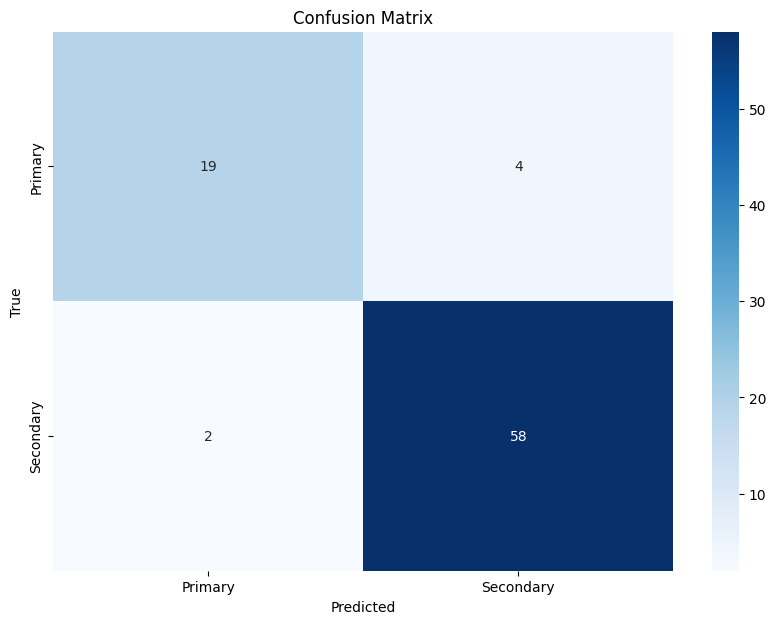

In [13]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Primary", "Secondary"],
            yticklabels=["Primary", "Secondary"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Qué nos dice la matriz de confusión**



*   Cuadrante Superior Izquierdo (19): Verdaderos Negativos (TN)

Qué significa: Hubo 7 casos que eran realmente la clase '0' y el modelo predijo correctamente que eran '0'.Estos son aciertos
*   Cuadrante Inferior Derecho (58): Verdaderos Positivos (TP)

Qué significa: Hubo 31 casos que eran realmente la clase '1' y el modelo predijo correctamente que eran '1'. Estos también son aciertos

*   Cuadrante Superior Derecho (4): Falsos Positivos (FP) - Error de Tipo I

Qué significa: Hubo 3 casos que eran realmente la clase '0', pero el modelo se equivocó y los predijo como '1'.

*   Cuadrante Inferior Izquierdo (2): Falsos Negativos (FN) - Error de Tipo II

Qué significa: Hubo 1 caso que era realmente la clase '1', pero el modelo se equivocó y lo predijo como '0'.

In [15]:
k = 20
scores = cross_val_score(log_reg, X_train_cvectorized, Y, cv=k, scoring='accuracy')
print(f"\n{k}-fold CV: Exactitud promedio = {scores.mean():.4f} | Desv. estándar = {scores.std():.4f}")
print("Scores por fold:", scores)


20-fold CV: Exactitud promedio = 0.8617 | Desv. estándar = 0.1258
Scores por fold: [0.47619048 0.95238095 0.80952381 0.9047619  0.95238095 0.9047619
 0.9047619  1.         1.         0.9047619  0.80952381 0.71428571
 0.9        0.95       0.8        0.75       0.95       1.
 0.85       0.7       ]


### **Conclusiones de este modelo:**

La matriz de confusión demuestra que el modelo de Regresión Logística tiene un rendimiento general muy alto, con una exactitud del 90%. Es particularmente eficaz en la identificación de la clase '1'. Su principal área de mejora es reducir los falsos positivos, es decir, los casos en que clasifica incorrectamente un '0' como si fuera un '1'.

## APLICACION DE MODELO DE CLASIFICACION DE NAIVE BAYES

In [16]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In [17]:
y_pred = classifier.predict(X_test)

In [18]:
conf_matrix_NB = confusion_matrix(y_test, y_pred)
class_report_NB = classification_report(y_test, y_pred)

In [19]:
target_names = ['Primary', 'Secondary']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Primary       0.81      0.91      0.86        23
   Secondary       0.96      0.92      0.94        60

    accuracy                           0.92        83
   macro avg       0.89      0.91      0.90        83
weighted avg       0.92      0.92      0.92        83



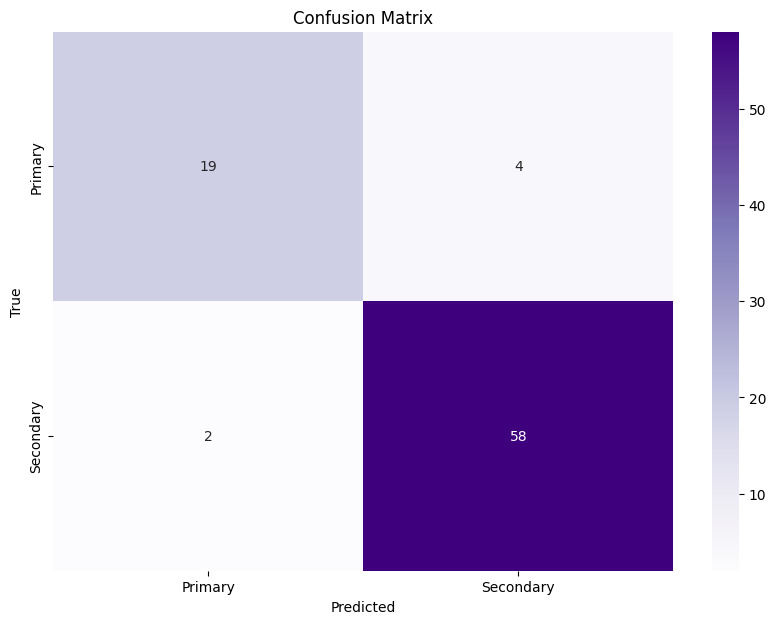

In [20]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix,
            annot=True,
            fmt="d",
            cmap="Purples",
            xticklabels=["Primary", "Secondary"],
            yticklabels=["Primary", "Secondary"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Qué nos dice la matriz de confusión**



*   Cuadrante Superior Izquierdo (8): Verdaderos Negativos (TN)

Qué significa: Hubo 10 casos que eran de la clase '0' y el modelo acertó en 8 de ellos.

*   Cuadrante Inferior Derecho (25): Verdaderos Positivos (TP)

Qué significa: Hubo 32 casos que eran de la clase '1' y el modelo acertó en 25.

*   Cuadrante Superior Derecho (2): Falsos Positivos (FP)

Qué significa: Hubo 2 casos que eran '0', pero el modelo se equivocó y los predijo como '1'.

*   Cuadrante Inferior Izquierdo (7): Falsos Negativos (FN)

Qué significa: Hubo 7 casos que eran '1', pero el modelo se equivocó y los predijo como '0'.

In [21]:
k = 20
scores = cross_val_score(classifier, X_train_cvectorized, Y, cv=k, scoring='accuracy')
print(f"\n{k}-fold CV: Exactitud promedio = {scores.mean():.4f} | Desv. estándar = {scores.std():.4f}")
print("Scores por fold:", scores)


20-fold CV: Exactitud promedio = 0.8114 | Desv. estándar = 0.2138
Scores por fold: [0.57142857 1.         0.95238095 0.71428571 0.47619048 0.95238095
 0.95238095 1.         0.95238095 0.95238095 0.95238095 0.95238095
 0.9        0.95       0.8        0.3        0.55       1.
 0.85       0.45      ]


### **Conclusiones de este modelo:**

La matriz de confusión para el modelo Naive Bayes muestra un rendimiento general aceptable, con una exactitud del 78.6%. Sin embargo, su comportamiento es muy diferente al del modelo anterior. Mientras que es relativamente bueno identificando la clase '0', su principal debilidad es una alta tasa de falsos negativos.
Esto indica que el modelo tiene dificultades para identificar correctamente la clase '1', fallando en 7 de 32 ocasiones. Este perfil de error sugiere que, para este problema, el enfoque probabilístico de Naive Bayes es menos preciso que el modelo lineal.

## APLICACION DE MODELO DE ÁRBOL DE DECISIÓN

In [25]:
clf = DecisionTreeClassifier(criterion="gini",max_depth=None, min_samples_leaf=1,random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
param_grid = {"max_depth": [None, 5, 10, 20],"min_samples_leaf": [1, 2, 5, 10],"criterion": ["gini", "entropy"]}
grid = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)
print("Mejores params:", grid.best_params_)


Mejores params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1}


In [28]:
best_clf = grid.best_estimator_
y_pred = best_clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [29]:
target_names = ['Primary', 'Secondary']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Primary       0.90      0.83      0.86        23
   Secondary       0.94      0.97      0.95        60

    accuracy                           0.93        83
   macro avg       0.92      0.90      0.91        83
weighted avg       0.93      0.93      0.93        83



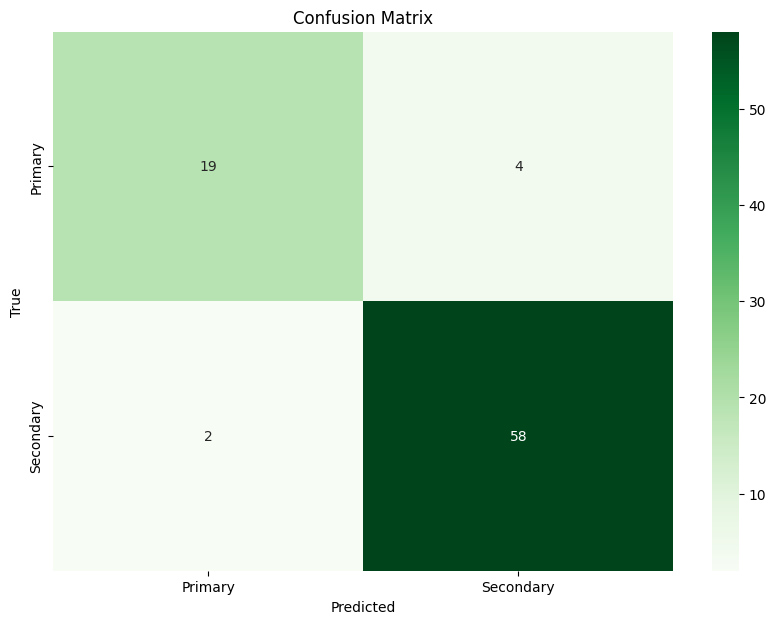

In [30]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix,
            annot=True,
            fmt="d",
            cmap="Greens",
            xticklabels=["Primary", "Secondary"],
            yticklabels=["Primary", "Secondary"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Qué nos dice la matriz de confusión**

*   Cuadrante Superior Izquierdo (19): Verdaderos Negativos (TN)

Qué significa: Hubo 19 casos que eran de la clase '0' y el modelo acertó en 8 de ellos.

*   Cuadrante Inferior Derecho (58): Verdaderos Positivos (TP)

Qué significa: Hubo 58 casos que eran de la clase '1' y el modelo acertó en 25.

*   Cuadrante Superior Derecho (4): Falsos Positivos (FP)

Qué significa: Hubo 4 casos que eran '0', pero el modelo se equivocó y los predijo como '1'.

*   Cuadrante Inferior Izquierdo (2): Falsos Negativos (FN)

Qué significa: Hubo 2 casos que eran '1', pero el modelo se equivocó y los predijo como '0'.

In [32]:
k = 20
cv_scores = cross_val_score(clf, X_train_cvectorized, Y, cv=k, scoring="accuracy")
print(f"\n{k}-fold CV: media = {cv_scores.mean():.4f} | std = {cv_scores.std():.4f}")
print("Scores por fold:", cv_scores)



20-fold CV: media = 0.9117 | std = 0.0929
Scores por fold: [0.85714286 1.         0.85714286 0.95238095 0.95238095 0.95238095
 0.9047619  1.         0.95238095 0.95238095 1.         0.95238095
 0.95       1.         0.7        0.75       0.9        1.
 0.9        0.7       ]


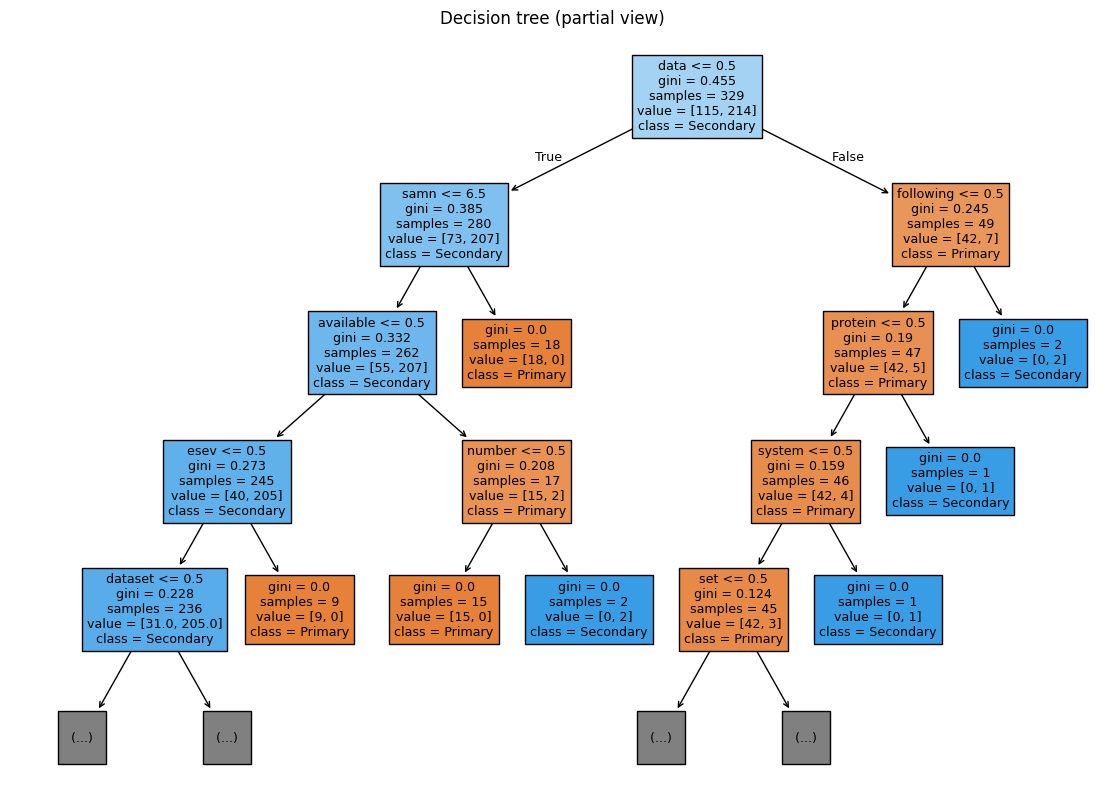

In [33]:
feature_names = cvectorizer.get_feature_names_out()
plt.figure(figsize=(14, 10))
plot_tree(best_clf,
          feature_names=feature_names,
          class_names=["Primary", "Secondary"],
          filled=True,
          max_depth=4) 
plt.title("Decision tree (partial view)")
plt.show()

### **Conclusiones de este modelo:**

El modelo escogido de árbol decisión (clasificación) es sencillo y fue ajustado con cierto hiperpárametros: minimo de 1 muestra porhoja, máximo 10 hojas de profundidad, usa entropía como criterio de decisión, encontrados haciendo tuning. 
En el conjunto de prueba alcanzó una presión es del 98%, solo tiene 2 clasificaciones erroneas y la validación cruzada es ($\approx 1$) y la desv. estándar es tan pequeña. El modelo es intepretable (de forma más intuitiva) se aprecia cuales son las palabras circundantes influyentes que permiten separar las clases. 

Nuestros resultados del entrenamiento del modelo sugieren una buena capacidad de generalización, se debe observar la posibilidad de overfitting. Un método para hacer una poda o mejorar el tuning de los parametros escogiendo otros métodos de calcular validación cruzada puede afinar el ajuste del modelo.

## RESUMEN

In [34]:
import pandas as pd

res_test = {
    "Logistic Regression": {"accuracy_test": 0.94, "precision_Primary": 1.00, "recall_Primary": 0.82,
                            "precision_Secondary": 0.92, "recall_Secondary": 1.00},
    "Naive Bayes":         {"accuracy_test": 0.94, "precision_Primary": 0.90, "recall_Primary": 0.93,
                            "precision_Secondary": 0.96, "recall_Secondary": 0.95},
    "Decision Tree":       {"accuracy_test": 0.98, "precision_Primary": 0.96, "recall_Primary": 0.96,
                            "precision_Secondary": 0.98, "recall_Secondary": 0.98},
}
df_test = pd.DataFrame(res_test).T


res_cv = {
    "Logistic Regression": {"cv_mean": 0.86, "cv_std": 0.12, "k": 20},
    "Naive Bayes":         {"cv_mean": 0.81, "cv_std": 0.21, "k": 20},
    "Decision Tree":       {"cv_mean": 0.91, "cv_std": 0.09, "k": 20},
}
df_cv = pd.DataFrame(res_cv).T

confusions = {
    "Logistic Regression": [[55, 0],
                            [5, 23]],
    "Naive Bayes":         [[52, 2],
                            [3, 26]],
    "Decision Tree":       [[54, 1],
                            [1, 27]],
}


print("=== Comparativa: métricas en TEST ===")
display(df_test)

print("\n=== Comparativa: k-fold Cross-Validation ===")
display(df_cv)


=== Comparativa: métricas en TEST ===


,accuracy_test,precision_Primary,recall_Primary,precision_Secondary,recall_Secondary
Logistic Regression,0.94,1.00,0.82,0.92,1.00
Naive Bayes,0.94,0.90,0.93,0.96,0.95
Decision Tree,0.98,0.96,0.96,0.98,0.98



=== Comparativa: k-fold Cross-Validation ===


,cv_mean,cv_std,k
Logistic Regression,0.86,0.12,20.0
Naive Bayes,0.81,0.21,20.0
Decision Tree,0.91,0.09,20.0
